In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import inspect
import re
import os
pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import sqlite3 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

In [3]:
db_path = os.path.join('..', 'data', 'database_credito.db')

try:
    conn = sqlite3.connect(db_path)
    print("Conectado a la base de datos con éxito")
except sqlite3.OperationalError as e:
    print(f"Error al abrir la base de datos: {e}")


Conectado a la base de datos con éxito


In [4]:

data_modelar = pd.read_sql('SELECT * FROM Datos_train_procesados', conn)
conn.close()

In [5]:
data_modelar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69511 entries, 0 to 69510
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Edad                              69511 non-null  int64  
 1   Ingreso_Anual                     69511 non-null  float64
 2   Salario_Mensual_En_Mano           69511 non-null  float64
 3   Numero_Cuentas_Bancarias          69511 non-null  int64  
 4   Numero_Tarjetas_Credito           69511 non-null  int64  
 5   Tasa_Interes                      69511 non-null  int64  
 6   Retraso_Promedio_Pagos            69511 non-null  int64  
 7   Numero_Promedio_Pagos_Retrasados  69511 non-null  float64
 8   Cambio_Limite_Credito             69511 non-null  float64
 9   Numero_Consultas_Credito          69511 non-null  float64
 10  Deuda_Pendiente                   69511 non-null  float64
 11  Ratio_Uso_Credito                 69511 non-null  float64
 12  Anti

In [ ]:
X = data_modelar.drop(columns=['Puntaje_Credito']) 
y = data_modelar['Puntaje_Credito'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('classifier', LogisticRegression())  
])


param_grid = [
    {'classifier': [LogisticRegression()]},
    {'classifier': [SVC()]},
    {'classifier': [RandomForestClassifier()]},
    {'classifier': [GradientBoostingClassifier()]},
    {'classifier': [AdaBoostClassifier()]},
    {'classifier': [KNeighborsClassifier()]},
    {'classifier': [GaussianNB()]},
    {'classifier': [DecisionTreeClassifier()]},
    {'classifier': [MLPClassifier()]},
    {'classifier': [LinearDiscriminantAnalysis()]},
    {'classifier': [QuadraticDiscriminantAnalysis()]},
    {'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')]}
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)


grid_search.fit(X_train, y_train)


means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

print("Resultados de precisión (accuracy) para cada modelo con StandardScaler:")
for mean, std, param in zip(means, stds, params):
    print(f"Classifier: {param['classifier'].__class__.__name__}: {mean:.2%} (+/- {std:.2%})")

best_model = grid_search.best_estimator_
print("\nMejor modelo:", best_model)

In [9]:
def plot_grid_search_results_with_values(grid_search):
    classifiers = [param['classifier'].__class__.__name__ for param in grid_search.cv_results_['params']]
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    sorted_indices = means.argsort()[::-1]
    classifiers = [classifiers[i] for i in sorted_indices]
    means = means[sorted_indices]
    stds = stds[sorted_indices]

    cmap = plt.get_cmap('coolwarm') 
    colors = cmap(means / max(means)) 

    plt.figure(figsize=(12, 8))
    bars = plt.barh(classifiers, means, xerr=stds, color=colors, edgecolor='black')
    plt.xlabel('Accuracy')
    plt.title('Comparación de Modelos - Precisión')
    plt.gca().invert_yaxis()

    for bar, mean in zip(bars, means):
        plt.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height()/2, f'{mean:.2%}', 
                 va='center', ha='right', fontsize=10, color='white' if mean / max(means) > 0.5 else 'black')

    plt.show()

plot_grid_search_results_with_values(grid_search)


NameError: name 'grid_search' is not defined

Con ello podemos ver que el mejor modelo para predecir nuestros valores sera el random forest classifier

Sin embargo unicamente hicimos una busqueda superficial con escalado estandar y sabemos que para algunos modelos de clasificacion como el random forest classifier puede no ser necesario escalar por lo que vamos a crear una funcion que muestre los resultados lado a lado para ver si es necesario o no escalarlos

agregando a esto, en nuestro archivo de optimizacion de random forest vimos que balancear el modelo nos beneficia para mejorar el rendimiento por loo que llamaremos al data set balanceado y probaremos los modelos con ese dataset

In [6]:
ruta_relativa = '../../data/Processed/Df_mod_blanceado.csv'
data_modelar_balanceado = pd.read_csv(ruta_relativa)
data_modelar_balanceado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90528 entries, 0 to 90527
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Edad                              90528 non-null  int64  
 1   Ingreso_Anual                     90528 non-null  float64
 2   Salario_Mensual_En_Mano           90528 non-null  float64
 3   Numero_Cuentas_Bancarias          90528 non-null  int64  
 4   Numero_Tarjetas_Credito           90528 non-null  int64  
 5   Tasa_Interes                      90528 non-null  int64  
 6   Retraso_Promedio_Pagos            90528 non-null  int64  
 7   Numero_Promedio_Pagos_Retrasados  90528 non-null  float64
 8   Cambio_Limite_Credito             90528 non-null  float64
 9   Numero_Consultas_Credito          90528 non-null  float64
 10  Deuda_Pendiente                   90528 non-null  float64
 11  Ratio_Uso_Credito                 90528 non-null  float64
 12  Anti

In [7]:
def buscar_mejores_modelos(data, target_column, test_size=0.2, random_state=42):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    classifiers = [
        LogisticRegression(),
        SVC(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        AdaBoostClassifier(),
        KNeighborsClassifier(),
        GaussianNB(),
        DecisionTreeClassifier(),
        MLPClassifier(),
        LinearDiscriminantAnalysis(),
        QuadraticDiscriminantAnalysis(),
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    ]

    param_grid = [{'scaler': [StandardScaler()], 'classifier': [clf]} for clf in classifiers] + [{'scaler': [None], 'classifier': [clf]} for clf in classifiers]

    pipeline = Pipeline([
        ('scaler', None),
        ('classifier', LogisticRegression())
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    results = pd.DataFrame({
        'Classifier': [param['classifier'].__class__.__name__ for param in grid_search.cv_results_['params']],
        'Scaler': ['StandardScaler' if param['scaler'] else 'None' for param in grid_search.cv_results_['params']],
        'Mean Accuracy': grid_search.cv_results_['mean_test_score'],
        'Std Accuracy': grid_search.cv_results_['std_test_score']
    })

    mejores_modelos = results.sort_values(by='Mean Accuracy', ascending=False)
    best_model = grid_search.best_estimator_

    return mejores_modelos, best_model



In [8]:

mejores_modelos, best_model = buscar_mejores_modelos(data_modelar_balanceado, 'Puntaje_Credito')
print("\nMejor modelo:", best_model)
mejores_modelos.head(10)


Mejor modelo: Pipeline(steps=[('scaler', None), ('classifier', RandomForestClassifier())])


,Classifier,Scaler,Mean Accuracy,Std Accuracy
14,RandomForestClassifier,None,0.851592,0.003716
2,RandomForestClassifier,StandardScaler,0.851468,0.004060
23,XGBClassifier,None,0.826255,0.004643
11,XGBClassifier,StandardScaler,0.826172,0.004411
5,KNeighborsClassifier,StandardScaler,0.778120,0.003284
19,DecisionTreeClassifier,None,0.768620,0.001113
7,DecisionTreeClassifier,StandardScaler,0.768289,0.001962
3,GradientBoostingClassifier,StandardScaler,0.765803,0.004014
15,GradientBoostingClassifier,None,0.765610,0.004233
1,SVC,StandardScaler,0.762945,0.003798


Una vez que vemos los resultados podemos determinar que la mejor forma de continuar es utilizando el random forest classifier sin escalar, ya que en las diferentes particiones que hizo nuestro grid search vemos un accuracy promedio de 85.16%


In [13]:
def plot_grid_search_results_with_values(df, characteristic, group_column):
    unique_groups = df[group_column].unique()
    
    for group in unique_groups:
        df_group = df[df[group_column] == group]
        
        classifiers = df_group['Classifier']
        means = df_group['Mean Accuracy']
        stds = df_group['Std Accuracy']
        
        sorted_indices = means.argsort()[::-1]
        classifiers = [classifiers.iloc[i] for i in sorted_indices]
        means = means.iloc[sorted_indices].values
        stds = stds.iloc[sorted_indices].values

        cmap = plt.get_cmap('coolwarm')
        colors = cmap(means / max(means))

        plt.figure(figsize=(12, 8))
        bars = plt.barh(classifiers, means, xerr=stds, color=colors, edgecolor='black')
        plt.xlabel('Accuracy')
        plt.title(f'Comparación de Modelos - {characteristic} ({group_column}: {group})')
        plt.gca().invert_yaxis()

        for bar, mean in zip(bars, means):
            plt.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height()/2, f'{mean:.2%}', 
                     va='center', ha='right', fontsize=10, color='white' if mean / max(means) > 0.5 else 'black')

        plt.show()


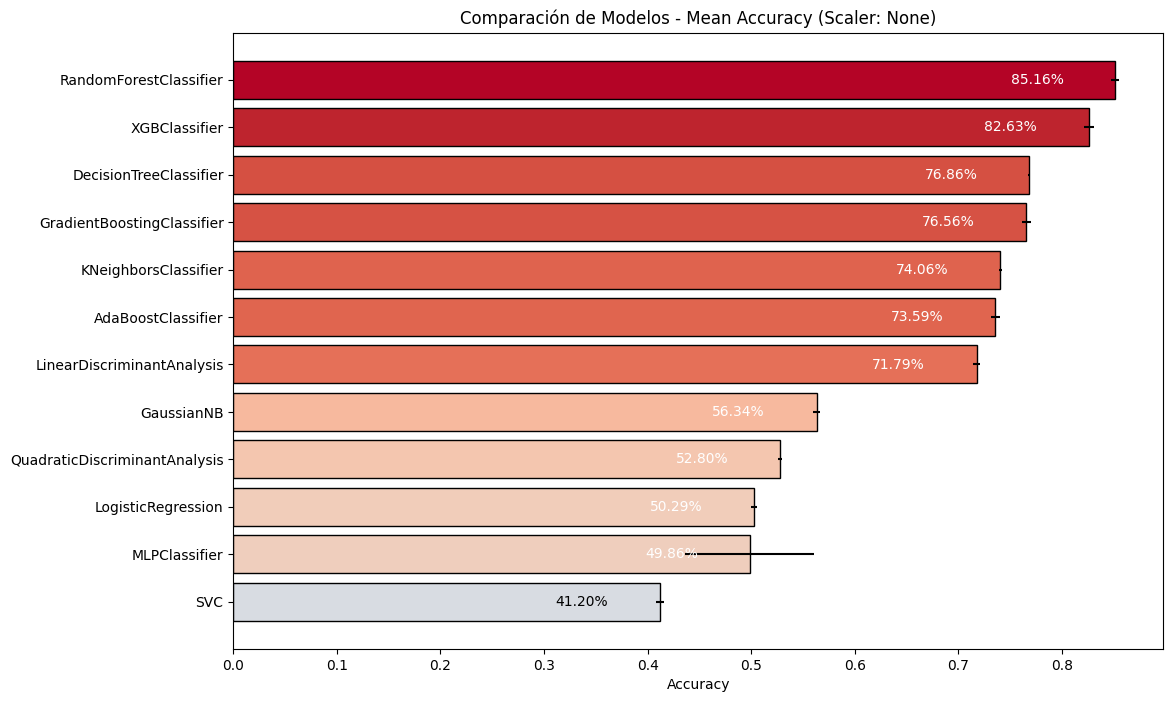

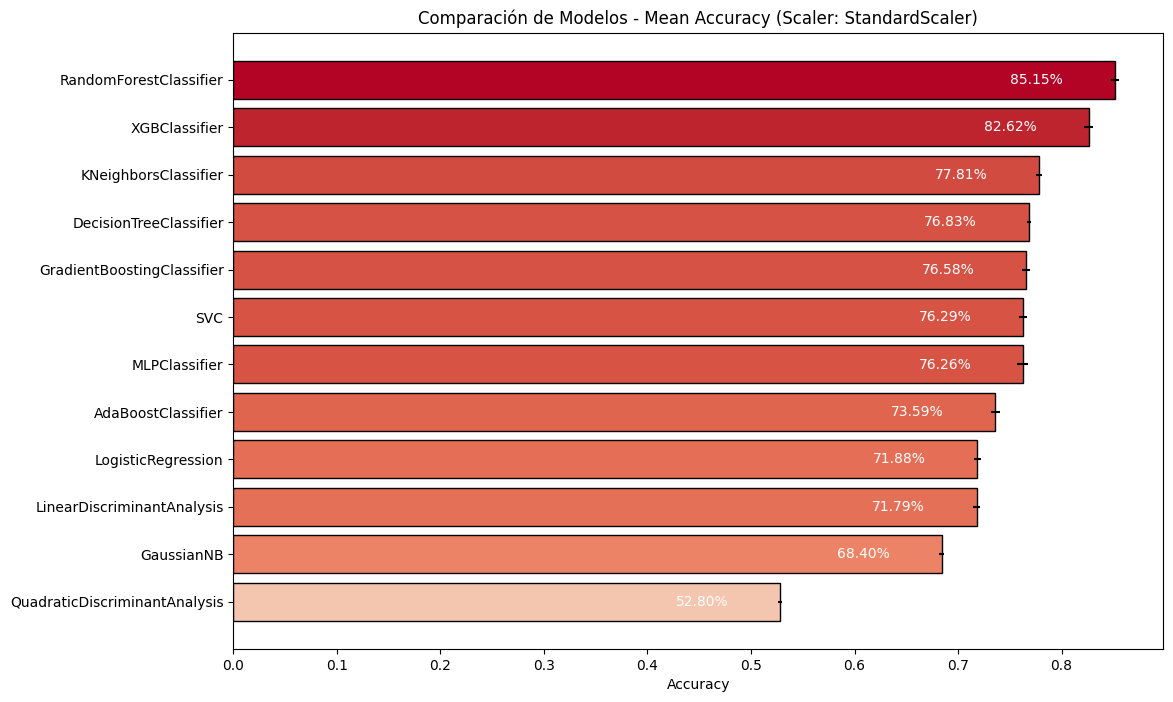

In [14]:
plot_grid_search_results_with_values(mejores_modelos, 'Mean Accuracy', 'Scaler')